In [123]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
import sympy as s
import csv
s.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)

def ll(a, b):
    return (a*b) / (a + b)

In [124]:
def parse(file, real_or_complex):
    with open('%s.csv' % file, 'r') as csvfile:
        next(csvfile)
        csvreader = csv.reader(csvfile, delimiter=',')
        data = []
        idsdata = []
        # Format is Ids, Vgs(L=45n), Ids, Vgs(L=90n), Ids, ...
        for row in csvreader:
            if (real_or_complex):
                val = list(map(lambda x: float(x), row[1::2]))
            else:
                val_real = list(map(lambda x: float(x), row[1::3]))
                val_imag = list(map(lambda x: float(x), row[2::3]))
                val = list(map(lambda n: np.abs(n[0] + n[1]*1j), zip(val_real, val_imag)))
            ids = float(row[0])
            data.append(val)
            idsdata.append(ids)
        return (np.array(idsdata), np.array(data))

In [127]:
# Gather data from ADE for Vgs, av0, gm vs Ids (for 4 different lengths = 45n, 90n, 135n, 1u=1000n)
(ids, vgs) = parse('vgs', True)
(ids, av0) = parse('av0', False)

Text(0.5,1,'$a_{v0}$ vs. $V_{gs}$ for minimum width and swept length')

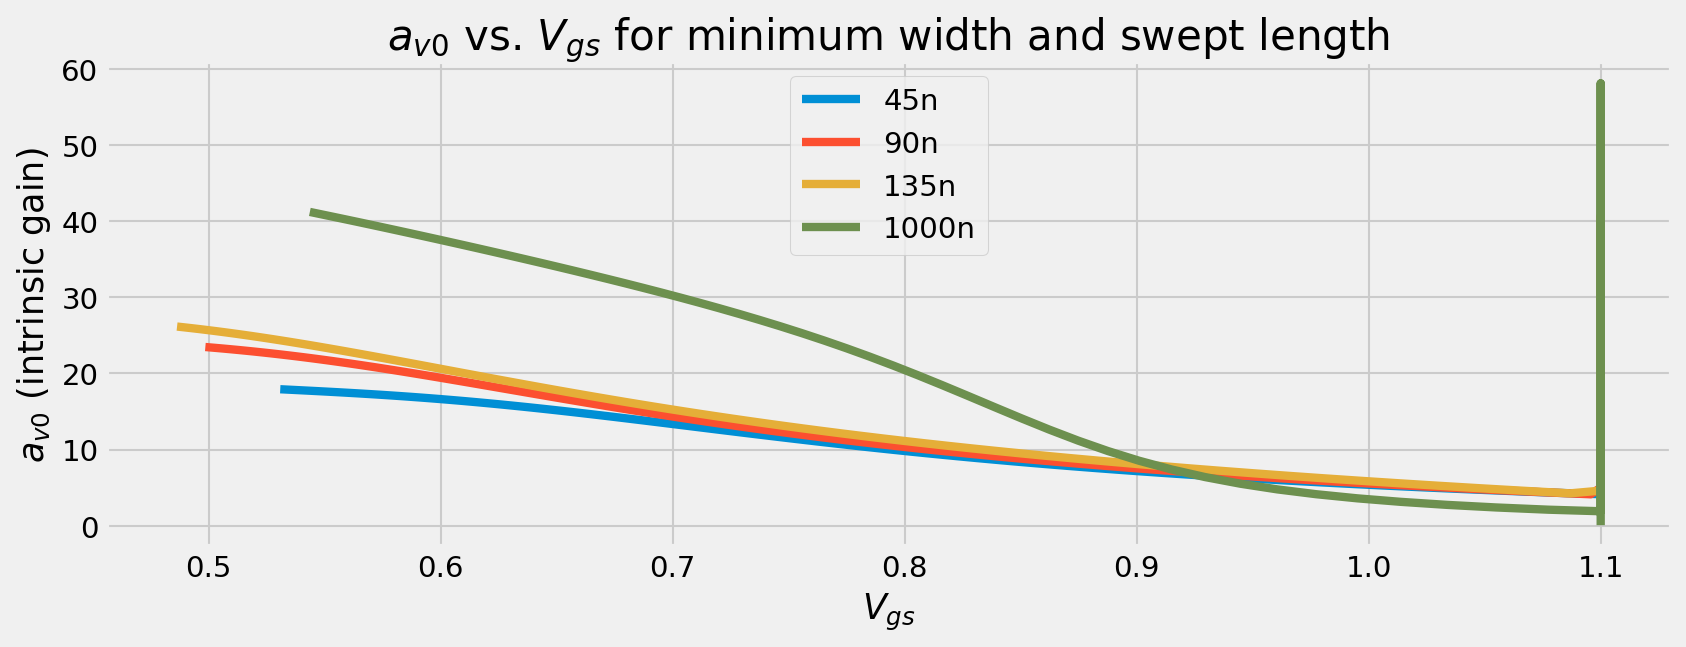

In [126]:
plt.style.use('fivethirtyeight')
w, h = figaspect(1/3)
fig, ax = plt.subplots(figsize=(w,h))
[plt.plot(vgs[:,l], av0[:,l]) for l in range(4)]
plt.legend(['45n', '90n', '135n', '1000n'])
plt.ylabel('$a_{v0}$ (intrinsic gain)')
plt.xlabel('$V_{gs}$')
plt.title('$a_{v0}$ vs. $V_{gs}$ for minimum width and swept length')